https://www.datacamp.com/tutorial/random-forests-classifier-python
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [1]:
import pandas as pd
from itertools import product
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
original = pd.read_csv('train.csv')


In [3]:
# drop rows where tempo is missing
original = original[original['Tempo'].notna()]
# drop rows where genre speechness and valence are missing
#original = original[original['Speechiness'].notna()]
# original = original[original['Valence'].notna()]

In [4]:
training_Y = original['Danceability']
original.drop(['Danceability'], axis=1, inplace=True) 

In [5]:
def fillOptions(data, option = 'max'):
    if data.isna().sum() != len(data):
        if option == 'max':
            return data.value_counts().idxmax()
        elif option == 'mean':
            return data.mean()
        elif option == 'median':
            return data.median()

In [6]:
def verifyID(original, newData):
    noInNewData = original[~original['id'].isin(newData['id'])]
    return pd.concat([newData, noInNewData], ignore_index=True)   

In [7]:
def filterArtistComposerDance(data, nameColumnFill):

    listArtist = data['Artist'].unique()
    listComposer = data['Composer'].unique()
    
    filter = list(product(listArtist, listComposer))

    newData = pd.DataFrame(columns=data.columns)

    for i in filter:
        artist, composer = i[0], i[1]
        filterData = data[(data['Artist'] == artist) & (data['Composer'] == composer) ]
        if len(filterData) != 0:
            # Fill column Name
            for nameColumn in nameColumnFill:
                fillInfo = fillOptions(filterData[nameColumn], option = 'max')
                if fillInfo != None:
                    filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

            newData = pd.concat([newData, filterData], ignore_index=True)
    return newData

In [8]:
def filterArtist(data, nameColumnFill):
    listDance = data['Artist'].unique()
    filter = listDance


    newData = pd.DataFrame(columns=data.columns)

    for i in filter:
        dance = i
        filterData = data[ (data['Artist'] == dance)]
    
    
        if len(filterData) != 0:
            # Fill column Name
            for nameColumn in nameColumnFill:
                fillInfo = fillOptions(filterData[nameColumn], option = 'max')
                if fillInfo != None:
                    filterData.loc[:,nameColumn].fillna(fillInfo, inplace=True)

            newData = pd.concat([newData, filterData], ignore_index=True)

    return newData

In [9]:
def filterFillData(data, nameColumnFill):
    if not data.isnull().any().any():
        return data
    else:
        for nameColumn in nameColumnFill:
            fillInfo = fillOptions(data[nameColumn], option = 'max')
            if fillInfo != None:
                data.loc[:,nameColumn].fillna(fillInfo, inplace=True)
    return data



In [10]:
def dataPreprocessing(original):
    
    pd.options.mode.chained_assignment = None

    data = original.copy()

    nameColumnFill = ['Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Duration_ms', 'Views', 'Likes', "Stream" , "Comments"]

    # License and official_video
    data['Licensed'].fillna(data['official_video'], inplace=True)
    data['Licensed'].fillna(False, inplace=True)

    data['official_video'].fillna(data['Licensed'], inplace=True)
    data['official_video'].fillna(False, inplace=True)

    data['official_video'].fillna(False, inplace=True)
    data['Licensed'].fillna(False, inplace=True)

    data['Licensed'].replace({True: 1, False: 0})
    data['official_video'].replace({True: 1, False: 0})

    # Create new class = 'Unknown'
    data['Composer'].fillna("Unknown", inplace=True)
    data['Artist'].fillna("Unknown", inplace=True)
    data['Album_type'].fillna("Unknown", inplace=True)

    

    newData = filterArtistComposerDance(data, nameColumnFill)
    data = newData.copy()

    newData = filterArtist(data, nameColumnFill)
    data = newData.copy()

    newData = filterFillData(data, nameColumnFill)
    data = newData.copy()

    #Transform type key to use as class
    data['Key'] = data['Key'].astype(int)
    data['Key'] = data['Key'].astype(str)

    data = data.sort_values('id')

    # DELETE Track, Album, Uri, Url_spotify, Url_youtube, Description, Title, Channel, id, Comments
    data.drop(['Track', 'Album', 'Uri', 'Url_spotify', 'Url_youtube', 'Description', 'Title', 'Channel', 'id'], axis=1, inplace=True)

    pd.options.mode.chained_assignment = 'warn'

    return data
    


In [11]:
def convertEncoderPD(data, prefix = 'key'):
    titleKeys = []
    for i in range(data.shape[1]):
        titleKeys.append(f'{prefix}_{i}')
    
    return pd.DataFrame(data=data, columns= titleKeys)


In [12]:
def createEncodeDataTraining(data):

    encoderKey = OneHotEncoder()
    encodedKey = encoderKey.fit_transform(data[['Key']])
    Key = encodedKey.toarray()
    key_pd = convertEncoderPD(Key, prefix = 'key')

    encoderAlbumType = OneHotEncoder()
    encodedKeyAlbumType = encoderAlbumType.fit_transform(data[['Album_type']])
    AlbumType = encodedKeyAlbumType.toarray()
    AlbumType_pd = convertEncoderPD(AlbumType, prefix = 'AlbumType')

    encoderComposer = OneHotEncoder()
    encodedKeyComposer = encoderComposer.fit_transform(data[['Composer']])
    Composer = encodedKeyComposer.toarray()
    Composer_pd = convertEncoderPD(Composer, prefix = 'Composer')   

    encoderArtist = LabelEncoder()
    encodedArtist = encoderArtist.fit_transform(data[['Artist']])
    encodedArtist = encodedArtist.ravel()
    Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

    data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

    data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

    scaler = StandardScaler()
    scaledData = scaler.fit_transform(data)

    scaledData_pd = pd.DataFrame(data=scaledData, columns= data.columns)

    return {"key": encoderKey, 'AlbumType': encoderAlbumType, 'Composer': encoderComposer, "Artist":encoderArtist} , scaler, data, scaledData_pd
    

In [13]:
def createEncodeDataTesting(encoder, scalerStandard, data):

    encoderKey = encoder['key']
    encodedKey = encoderKey.transform(data[['Key']])
    Key = encodedKey.toarray()
    key_pd = convertEncoderPD(Key, prefix = 'key')

    encoderAlbumType = encoder['AlbumType']
    encodedKeyAlbumType = encoderAlbumType.transform(data[['Album_type']])
    AlbumType = encodedKeyAlbumType.toarray()
    AlbumType_pd = convertEncoderPD(AlbumType, prefix = 'AlbumType')

    encoderComposer = encoder['Composer']
    encodedKeyComposer = encoderComposer.transform(data[['Composer']])
    Composer = encodedKeyComposer.toarray()
    Composer_pd = convertEncoderPD(Composer, prefix = 'Composer')   

    encoderArtist = encoder['Artist']
    encodedArtist = encoderArtist.transform(data[['Artist']])
    encodedArtist = encodedArtist.ravel()
    Artist_pd =  pd.DataFrame(data=encodedArtist, columns= ["Artist"])

    data.drop(['Key','Album_type', 'Composer',  'Artist'], axis=1, inplace=True)

    data = pd.concat([data, key_pd, AlbumType_pd, Composer_pd, Artist_pd], axis=1)

    scaler = scalerStandard
    scaledData = scaler.transform(data)

    scaledData_pd = pd.DataFrame(data=scaledData, columns= data.columns)

    return data, scaledData_pd

In [14]:
data = dataPreprocessing(original)

/tmp/ipykernel_39459/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_39459/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_39459/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_39459/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Exp

In [15]:
encoders, scalerStandard, data, scaledData_pd = createEncodeDataTraining(data)

/home/zow/anaconda3/envs/fintech2/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
test = pd.read_csv('test.csv')
dataTest = dataPreprocessing(test)
testOriginal, testScaled = createEncodeDataTesting(encoders, scalerStandard, dataTest)

/tmp/ipykernel_39459/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_39459/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_39459/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  newData = pd.concat([newData, filterData], ignore_index=True)
/tmp/ipykernel_39459/570975428.py:20: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Exp

In [17]:
scaledData_pd

Energy  Loudness  Speechiness  Acousticness  Instrumentalness  \
0     -1.393682 -3.772844    -0.477670      2.617848         -0.262135   
1     -0.631003 -1.297983    -0.580081      2.392443          4.895343   
2      0.198322 -1.695826    -0.478665      2.372504          4.651621   
3     -0.525836  0.330243    -0.642720     -0.508920         -0.262486   
4      0.076649  0.615346    -0.659623     -0.525385         -0.259839   
...         ...       ...          ...           ...               ...   
14603  1.897359  0.310080    -0.592012     -0.135112         -0.262486   
14604  2.005173  1.298290     0.682648     -0.525303         -0.262486   
14605  0.975926  0.671065    -0.274838     -0.438050         -0.262486   
14606  0.476022 -0.871089     3.247877     -0.329559         -0.262486   
14607  2.027015  0.700551     0.145740     -0.525398          4.901011   

       Liveness   Valence     Tempo  Duration_ms     Views     Likes  \
0     -0.282206 -0.782981 -1.265492    -0.928189 -0.216233 -0.279446   
1      0.022514  0.871506  0.935612    -0.443683 -0.346047 -0.361218   
2     -0.273601 -0.619978 -1.214892    -0.642303 -0.346047 -0.361218   
3     -0.280484 -0.848183  0.987122     0.355446  0.510942  0.251211   
4     -0.263319 -0.966360 -0.773350     0.345558  0.994915  0.437716   
...         ...       ...       ...          ...       ...       ...   
14603 -0.284136  0.512898 -1.042867    -1.130997 -0.341090 -0.363735   
14604 -0.282390  0.508823  1.818056    -0.640645 -0.346133 -0.363176   
14605 -0.256824 -0.461049  1.599577    -0.762949 -0.346680 -0.364219   
14606 -0.278167  0.027962  1.161001    -1.011267 -0.346803 -0.325406   
14607 -0.266965 -1.847803  1.319070    -0.373233 -0.346158 -0.362889   

         Stream  Licensed  official_video  Comments     key_0     key_1  \
0     -0.450898 -1.530368       -1.782832 -0.103597 -0.359152 -0.338281   
1     -0.486658 -1.530368       -1.782832 -0.117792  2.784339 -0.338281   
2     -0.453773 -1.530368       -1.782832 -0.117792 -0.359152 -0.338281   
3      1.201563  0.653437        0.560905 -0.001129 -0.359152 -0.338281   
4     -0.471746  0.653437        0.560905  0.031615 -0.359152 -0.338281   
...         ...       ...             ...       ...       ...       ...   
14603  0.009100  0.653437        0.560905 -0.118380 -0.359152 -0.338281   
14604 -0.490431  0.653437        0.560905 -0.118380 -0.359152  2.956124   
14605 -0.222767  0.653437        0.560905 -0.118380 -0.359152 -0.338281   
14606 -0.507945  0.653437        0.560905 -0.118380 -0.359152 -0.338281   
14607 -0.513074  0.653437        0.560905 -0.118380 -0.359152 -0.338281   

          key_2     key_3     key_4     key_5     key_6     key_7     key_8  \
0     -0.472164 -0.317013  5.826437 -0.263735 -0.285646 -0.263884 -0.359030   
1     -0.472164 -0.317013 -0.171631 -0.263735 -0.285646 -0.263884 -0.359030   
2     -0.472164 -0.317013 -0.171631 -0.263735  3.500843 -0.263884 -0.359030   
3      2.117910 -0.317013 -0.171631 -0.263735 -0.285646 -0.263884 -0.359030   
4     -0.472164  3.154445 -0.171631 -0.263735 -0.285646 -0.263884 -0.359030   
...         ...       ...       ...       ...       ...       ...       ...   
14603 -0.472164 -0.317013 -0.171631 -0.263735 -0.285646  3.789548 -0.359030   
14604 -0.472164 -0.317013 -0.171631 -0.263735 -0.285646 -0.263884 -0.359030   
14605  2.117910 -0.317013 -0.171631 -0.263735 -0.285646 -0.263884 -0.359030   
14606 -0.472164 -0.317013 -0.171631  3.791681 -0.285646 -0.263884 -0.359030   
14607 -0.472164 -0.317013 -0.171631 -0.263735 -0.285646 -0.263884  2.785282   

          key_9    key_10  AlbumType_0  AlbumType_1  AlbumType_2  AlbumType_3  \
0     -0.275136 -0.315835    -0.416786     0.805571    -0.172685    -0.525811   
1     -0.275136 -0.315835    -0.416786     0.805571    -0.172685    -0.525811   
2     -0.275136 -0.315835    -0.416786     0.805571    -0.172685    -0.525811   
3     -0.275136 -0.315835    -0.416786     0.805571    -0.172685    -0.525811   


In [20]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
#train_features, test_features, train_labels, test_labels = train_test_split(scaledData_pd, training_Y, test_size = 0.20, random_state = 123)
train_features, val_features, train_labels, val_labels = train_test_split(scaledData_pd, training_Y, test_size = 0.20, random_state = 123)

### RandomForestRegressor

In [17]:
#scaledData_pd, training_Y is the full training set
full_train_X = scaledData_pd
full_train_Y = training_Y

In [20]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
import pickle

#Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

# filename = "random_forest_regressor.joblib"
# pickle.dump(rf, open(filename, "wb"))

RandomForestRegressor(n_estimators=1000, random_state=42)

In [21]:
# Use the forest's predict method on the val data
predictions = rf.predict(val_features)
# Calculate the absolute errors
predictions = np.rint(predictions)
errors = abs(predictions - val_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.7


In [22]:
rf.fit(full_train_X, full_train_Y)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [23]:
# Use the forest's predict method on the test data
predictionsTest = rf.predict(testScaled)
predictionsTest = np.rint(predictionsTest)


In [24]:
predictionTest_pd = pd.DataFrame(data = predictionsTest, columns= ['Danceability'])
predictionTest_pd.to_csv('RandomForestRegressor.csv')

In [25]:
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submissionRF.csv', index=False)

# XGBOOST

In [33]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
best_params = {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.4, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 30, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6, 'colsample_bynode': 0.6, 'colsample_bylevel': 0.8, 'random_state': 0}
default_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 0,
    'n_jobs': -1
}


In [ ]:

best_model = XGBRegressor(**default_params)
best_model.fit(train_features, train_labels)


In [29]:

preds = best_model.predict(val_features)
mae = mean_absolute_error(val_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 1.7462629861635661


In [30]:
best_model.feature_importances_

array([0.08594095, 0.04444504, 0.14297625, 0.10396016, 0.03172156,
       0.03280337, 0.24423318, 0.11736909, 0.03352452, 0.02042207,
       0.03320416, 0.01216538, 0.01021645, 0.        , 0.01933899,
       0.00342533, 0.        , 0.        , 0.        , 0.01102375,
       0.        , 0.00550921, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00881779, 0.01198588, 0.        ,
       0.        , 0.        , 0.0117229 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00694072,
       0.        , 0.00825316], dtype=float32)

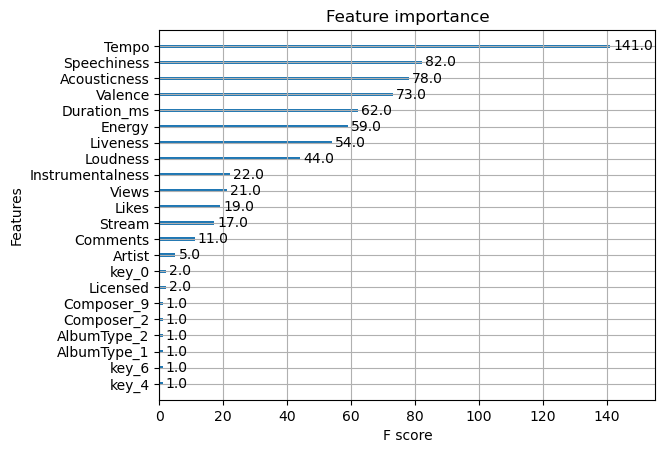

In [31]:
# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(best_model)
pyplot.show()

In [32]:
# Use the forest's predict method on the test data
predictionsTest = best_model.predict(testScaled)
predictionsTest = np.rint(predictionsTest)
predictionTest_pd = pd.DataFrame(data = predictionsTest, columns= ['Danceability'])
predictionTest_pd.to_csv('XGB.csv')


In [33]:
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submission.csv', index=False)

# ADABOOST Full-OVO

In [145]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsOneClassifier

ovo_classifier = OneVsOneClassifier(AdaBoostClassifier(n_estimators=50, random_state=42))

# Train the OvO classifier
ovo_classifier.fit(train_features, train_labels)

# Make predictions on the test set
preds = ovo_classifier.predict(val_features)
mae = mean_absolute_error(val_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 1.9650924024640657


# ADABOOST

In [96]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
base_estimator = DecisionTreeRegressor(max_depth=3, splitter='best', min_samples_split=2)
model = AdaBoostRegressor(base_estimator=base_estimator,n_estimators=500, random_state=42) #n_estimators = 1000, random_state = 42
model.fit(train_features, train_labels)

/opt/miniconda/lib/python3.10/site-packages/scikit_learn-1.2.2-py3.10-linux-x86_64.egg/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  n_estimators=500, random_state=42)

In [97]:

preds = model.predict(val_features)
mae = mean_absolute_error(val_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 2.052907470942129


In [98]:
train_features.shape

(11686, 42)

# LIGHTGBM

In [23]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_features, train_labels)
lgb_eval = lgb.Dataset(val_features, val_labels, reference=lgb_train)
params = {'boosting_type': 'gbdt',
              'objective': 'regression',
              'num_leaves': 40,
              'learning_rate': 0.1,
              'feature_fraction': 0.9
              }
gbm = lgb.train(params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['train','valid'],
   )


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3496
[LightGBM] [Info] Number of data points in the train set: 11686, number of used features: 42
[LightGBM] [Info] Start training from score 4.588054
[1]	train's l2: 7.68666	valid's l2: 7.71662
[2]	train's l2: 7.16593	valid's l2: 7.25274
[3]	train's l2: 6.73491	valid's l2: 6.85736
[4]	train's l2: 6.37208	valid's l2: 6.52526
[5]	train's l2: 6.11584	valid's l2: 6.30039
[6]	train's l2: 5.84342	valid's l2: 6.06456
[7]	train's l2: 5.61025	valid's l2: 5.86205
[8]	train's l2: 5.40195	valid's l2: 5.68031
[9]	train's l2: 5.2234	valid's l2: 5.5363
[10]	train's l2: 5.06316	valid's l2: 5.39821
[11]	train's l2: 4.92742	valid's l2: 5.28455
[12]	train's l2: 4.8131	valid's l2: 5.19685
[13]	train's l2: 4.70696	valid's l2: 5.11675
[14]	train's l2: 4.61407	valid's l2: 5.04937
[15]	train's l2: 4.52617	valid's l2: 

In [37]:

preds = gbm.predict(val_features)
mae = mean_absolute_error(val_labels, preds)
print(f"MAE without CV: {mae}")

MAE without CV: 1.6637101676438146


In [38]:
# Use the forest's predict method on the test data
predictionsTest = gbm.predict(testScaled)
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submission.csv', index=False)

# LightGBM OVO

In [26]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
#add OVO to LightGBM
from sklearn.multiclass import OneVsOneClassifier
lgbmCparams = {'boosting_type': 'gbdt',
              'objective': 'regression',
              'num_leaves': 40,
              'learning_rate': 0.1,
              'feature_fraction': 0.9
              }


In [ ]:
ovo_classifier = OneVsOneClassifier(lgb.LGBMClassifier(**lgbmCparams))
# Train the OvO classifier
ovo_classifier.fit(train_features, train_labels)

# Make predictions on the test set
preds = ovo_classifier.predict(val_features)
mae = mean_absolute_error(val_labels, preds)
print(f"MAE without CV: {mae}")

# CATBOOST

In [47]:
#try CatBoost
from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=1500, learning_rate=0.1, depth=3)
# Fit model
model.fit(train_features, train_labels)
# Get predictions
preds = model.predict(val_features)
mae = mean_absolute_error(val_labels, preds)
print(f"MAE without CV: {mae}")

0:	learn: 2.8000712	total: 2.23ms	remaining: 3.35s
1:	learn: 2.7485869	total: 3.74ms	remaining: 2.8s
2:	learn: 2.7054123	total: 5.21ms	remaining: 2.6s
3:	learn: 2.6707717	total: 6.78ms	remaining: 2.54s
4:	learn: 2.6359823	total: 8.88ms	remaining: 2.65s
5:	learn: 2.6076030	total: 10.4ms	remaining: 2.6s
6:	learn: 2.5797372	total: 12ms	remaining: 2.56s
7:	learn: 2.5540605	total: 13.3ms	remaining: 2.48s
8:	learn: 2.5290470	total: 14.6ms	remaining: 2.42s
9:	learn: 2.5034499	total: 15.9ms	remaining: 2.37s
10:	learn: 2.4820904	total: 17.2ms	remaining: 2.33s
11:	learn: 2.4648146	total: 18.6ms	remaining: 2.31s
12:	learn: 2.4469871	total: 19.9ms	remaining: 2.27s
13:	learn: 2.4319566	total: 21.3ms	remaining: 2.26s
14:	learn: 2.4176069	total: 22.7ms	remaining: 2.25s
15:	learn: 2.4031590	total: 24.2ms	remaining: 2.24s
16:	learn: 2.3900603	total: 25.5ms	remaining: 2.23s
17:	learn: 2.3808812	total: 26.8ms	remaining: 2.2s
18:	learn: 2.3697543	total: 28ms	remaining: 2.18s
19:	learn: 2.3590316	total: 29

# Ensemble

In [28]:
class LGBWrapper:
    def __init__(self, params=None, num_boost_round=10):
        self.params = params
        self.num_boost_round = num_boost_round
        self.model = None

    def fit(self, X, y):
        lgb_train = lgb.Dataset(X, y, free_raw_data=False)
        self.model = lgb.train(self.params, lgb_train, num_boost_round=self.num_boost_round)

    def predict(self, X):
        return self.model.predict(X)


In [30]:
# Prepare LightGBM parameters
lgbmRparams = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1
}

In [55]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier

# Instantiate the classfiers and make a list
regressors = [
    LGBWrapper(lgbmRparams, num_boost_round=200),
    RandomForestRegressor(n_estimators=1000, random_state=42),
    RandomForestRegressor(n_estimators=2000, random_state=42),
    XGBRegressor(**default_params),
    OneVsOneClassifier(AdaBoostClassifier(n_estimators=50, random_state=42)),
    OneVsOneClassifier(CatBoostRegressor(iterations=1500, learning_rate=0.1, depth=3)),
    #OneVsOneClassifier(lgb.LGBMClassifier(**lgbmCparams)),
    # AdaBoostRegressor(base_estimator=base_estimator, n_estimators=500, random_state=42),
    
]
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['regressors', 'mae'])

# Train and evaluate each classifier
for reg in regressors:
    reg.fit(train_features, train_labels)
    pred = reg.predict(val_features)
    mae = mean_absolute_error(val_labels, pred)
    result_table = result_table.append({'regressors':reg.__class__.__name__, 'mae': mae}, ignore_index=True)

result_table.set_index('mae', inplace=True)
result_table.sort_values(by=['mae'], ascending=True)




/tmp/ipykernel_39459/4199360003.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'regressors':reg.__class__.__name__, 'mae': mae}, ignore_index=True)
/tmp/ipykernel_39459/4199360003.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'regressors':reg.__class__.__name__, 'mae': mae}, ignore_index=True)
/tmp/ipykernel_39459/4199360003.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'regressors':reg.__class__.__name__, 'mae': mae}, ignore_index=True)
/tmp/ipykernel_39459/4199360003.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

0:	learn: 0.4950765	total: 1.46ms	remaining: 2.19s
1:	learn: 0.4918464	total: 2.36ms	remaining: 1.77s
2:	learn: 0.4882724	total: 3.1ms	remaining: 1.55s
3:	learn: 0.4850160	total: 3.99ms	remaining: 1.49s
4:	learn: 0.4821840	total: 4.69ms	remaining: 1.4s
5:	learn: 0.4801799	total: 5.51ms	remaining: 1.37s
6:	learn: 0.4775748	total: 6.31ms	remaining: 1.34s
7:	learn: 0.4759252	total: 7.13ms	remaining: 1.33s
8:	learn: 0.4738307	total: 7.86ms	remaining: 1.3s
9:	learn: 0.4722042	total: 8.53ms	remaining: 1.27s
10:	learn: 0.4704708	total: 9.28ms	remaining: 1.25s
11:	learn: 0.4694583	total: 9.96ms	remaining: 1.24s
12:	learn: 0.4678134	total: 10.7ms	remaining: 1.23s
13:	learn: 0.4667993	total: 11.5ms	remaining: 1.22s
14:	learn: 0.4660969	total: 12.2ms	remaining: 1.21s
15:	learn: 0.4653355	total: 12.9ms	remaining: 1.2s
16:	learn: 0.4644878	total: 13.7ms	remaining: 1.19s
17:	learn: 0.4635757	total: 14.7ms	remaining: 1.21s
18:	learn: 0.4627719	total: 15.5ms	remaining: 1.21s
19:	learn: 0.4621692	total

/tmp/ipykernel_39459/4199360003.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_table = result_table.append({'regressors':reg.__class__.__name__, 'mae': mae}, ignore_index=True)


regressors
mae                            
1.689389             LGBWrapper
1.711413  RandomForestRegressor
1.712485  RandomForestRegressor
1.746263           XGBRegressor
1.965092     OneVsOneClassifier
3.074606     OneVsOneClassifier

In [56]:
result_table

regressors
mae                            
1.689389             LGBWrapper
1.712485  RandomForestRegressor
1.711413  RandomForestRegressor
1.746263           XGBRegressor
1.965092     OneVsOneClassifier
3.074606     OneVsOneClassifier

In [57]:
# train on the full training set
for reg in regressors:
    reg.fit(full_train_X, full_train_Y)

0:	learn: 0.4953022	total: 1.1ms	remaining: 1.65s
1:	learn: 0.4912395	total: 2.15ms	remaining: 1.61s
2:	learn: 0.4871271	total: 2.96ms	remaining: 1.48s
3:	learn: 0.4838879	total: 3.73ms	remaining: 1.4s
4:	learn: 0.4814126	total: 4.52ms	remaining: 1.35s
5:	learn: 0.4794413	total: 5.25ms	remaining: 1.31s
6:	learn: 0.4773528	total: 6.04ms	remaining: 1.29s
7:	learn: 0.4753805	total: 6.83ms	remaining: 1.27s
8:	learn: 0.4739204	total: 7.61ms	remaining: 1.26s
9:	learn: 0.4727175	total: 8.39ms	remaining: 1.25s
10:	learn: 0.4711111	total: 9.24ms	remaining: 1.25s
11:	learn: 0.4702757	total: 10.1ms	remaining: 1.25s
12:	learn: 0.4690696	total: 10.8ms	remaining: 1.24s
13:	learn: 0.4682336	total: 11.6ms	remaining: 1.23s
14:	learn: 0.4674036	total: 12.4ms	remaining: 1.22s
15:	learn: 0.4664802	total: 13.2ms	remaining: 1.23s
16:	learn: 0.4656750	total: 14ms	remaining: 1.22s
17:	learn: 0.4648506	total: 14.9ms	remaining: 1.22s
18:	learn: 0.4640911	total: 15.8ms	remaining: 1.23s
19:	learn: 0.4633390	total

In [61]:
scaledData_pd.shape

(14608, 42)

In [62]:
def ensemble_predict(regressors, X):
    # Initialize an empty array of predictions
    predictions = np.zeros((X.shape[0], len(regressors)))

    # Generate predictions for each regressor
    for i, reg in enumerate(regressors):
        predictions[:, i] = reg.predict(X)

    # Average the predictions
    avg_predictions = predictions.mean(axis=1)
    
    return avg_predictions

# Make ensemble predictions
ensemble_predictions = ensemble_predict(regressors, testScaled)


In [60]:
# A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. 
# Then it averages the individual predictions to form a final prediction.
# predictionsTest = reg.predict(testScaled)
predictionsTest = ensemble_predictions
preds = np.rint(predictionsTest)
preds = preds.astype(int)
preds = pd.DataFrame(preds, columns=['Danceability'])
preds['id'] = preds.index + 17170
preds = preds[['id', 'Danceability']]
preds.to_csv('submission_ens_CatBoostOVO.csv', index=False)